In [2]:
pip install tensorflow-gpu

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd
from matplotlib import gridspec
from scipy import stats, interpolate
import os
from tensorflow.keras import backend as K  

import tqdm

In [4]:
def load (basedir, name, model=None):

    # Import(s)
    from keras.models import load_model

    # Load full pre-trained model or model weights
    if model is None:
        model = load_model(basedir + '{}.h5'.format(name))
    else:
        model.load_weights(basedir + '{}_weights.h5'.format(name))
        pass

    # Load associated training histories
    try:
        history_file = basedir + 'history__{}.json'.format(name)
        with open(history_file, 'r') as f:
            history = json.load(f)
            pass
    except:
        print ("[WARN] Could not find history file {}.") #
        history = None
        pass

    return model, history

In [5]:
def load_data (path, name='dataset', train=None, test=None, signal=None, background=None, sample=None, seed=21, replace=True):
    """
    General script to load data, common to all run scripts.

    Arguments:
        path: The path to the HDF5 file, from which data should be loaded.
        name: Name of the dataset, as stored in the HDF5 file.
        ...

    Returns:
        Tuple of pandas.DataFrame containing the loaded; list of loaded features
        to be used for training; and list of features to be used for mass-
        decorrelation.

    Raises:
        IOError: If no HDF5 file exists at the specified `path`.
        KeyError: If the HDF5 does not contained a dataset named `name`.
        KeyError: If any of the necessary features are not present in the loaded
            dataset.
    """

    # Check(s)
    #assert False not in [train, test, signal, background]
    #if sample: assert 0 < sample and sample < 1.

    # Read data from HDF5 file
    data = pd.read_hdf(path)

    # Subsample signal by x10 for testing: 1E+07 -> 1E+06
    np.random.seed(7)
    try:
        msk_test  = data['train'] == 0
        msk_train = ~msk_test
        msk_bkg = data['signal'] == 0
        msk_sig = ~msk_bkg
        #idx_sig = np.where(msk_sig)[0]
        #idx_sig = np.random.choice(idx_sig, int(msk_sig.sum() * 0.1), replace=False)
        #msk_sig = np.zeros_like(msk_bkg).astype(bool)
        #msk_sig[idx_sig] = True
        #data = data[msk_train | (msk_test & (msk_sig | msk_bkg))]
    except:
        log.warning("Some of the keys ['train', 'signal'] were not present in file {}".format(path))
        pass



    # Define feature collections to use
    features_input = ['Tau21pJ1', 'Tau21J2', 'Tau32J1', 'Tau32J2']
    features_decorrelation = ['m']

    # Split data
    if train:
        log.info("load_data: Selecting only training data.")
        data = data[data['train']  == 1]
        pass

    if test:
        # log.info("load_data: Selecting only testing data.")
        data = data[data['train']  == 0]
        pass

    if signal:
        log.info("load_data: Selecting only signal data.")
        data = data[data['signal'] == 1]
        pass

    if background:
        log.info("load_data: Selecting only background data.")
        data = data[data['signal'] == 0]
        pass

    if sample:
        log.info("load_data: Selecting a random fraction {:.2f} of data (replace = {}, seed = {}).".format(sample, replace, seed))
        data = data.sample(frac=sample, random_state=seed, replace=False)
        pass

    # Return
    return data, features_input, features_decorrelation


In [6]:
alpha = 0.1

def load_dataT21(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2"]]
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)

    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])
    
    #pT
    dataset["pT1"] = (input_frame["pxj1"]**2+input_frame["pyj1"]**2)**0.5/1000.
    dataset["pT2"] = (input_frame["pxj2"]**2+input_frame["pyj2"]**2)**0.5/1000.
    dataset["pTjOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["pT2"]
    dataset["pTjTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["pT2"]    
    

    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","pT1", "pT2", "mjOne","mjDelta", "tau21jOne", "tau21jTwo"]]
    return dataset.to_numpy()

def load_dataT32(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2","tau3j1","tau3j2"]]
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)

    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau3jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau3jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau32jOne"] = dataset["tau3jOne"]/dataset["tau2jOne"]
    dataset["tau32jTwo"] = dataset["tau3jTwo"]/dataset["tau2jTwo"] 
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])

    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta", "tau32jOne", "tau32jTwo"]]
    return dataset.to_numpy()

def load_data_more(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2","tau3j1","tau3j2"]]
    
    #Masa ya al cuadrado
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    
    
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)

    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
    
    #tau32
    dataset["tau3jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau3jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau32jOne"] = dataset["tau3jOne"]/dataset["tau2jOne"]
    dataset["tau32jTwo"] = dataset["tau3jTwo"]/dataset["tau2jTwo"]   
    
    #pT
    dataset["pT1"] = (input_frame["pxj1"]**2+input_frame["pyj1"]**2)**0.5/1000.
    dataset["pT2"] = (input_frame["pxj2"]**2+input_frame["pyj2"]**2)**0.5/1000.
    dataset["pTjOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["pT2"]
    dataset["pTjTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["pT2"]    
    
    #eta
    dataset["E1"] = ((1000*dataset["pT1"])**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5/1000.
    dataset["E2"] = ((1000*dataset["pT2"])**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5/1000.
    dataset["y1"] = 0.5*np.log((dataset["E1"] + input_frame["pzj1"]/1000.)/(dataset["E1"] - input_frame["pzj1"]/1000.))
    dataset["y2"] = 0.5*np.log((dataset["E2"] + input_frame["pzj2"]/1000.)/(dataset["E2"] - input_frame["pzj2"]/1000.))
    dataset["Dy"] = dataset["y1"]-dataset["y2"]
    
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])

    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta", "tau21jOne", "tau21jTwo", "tau32jOne", "tau32jTwo","pTjOne","pTjTwo","Dy"]]
    return dataset.to_numpy()

column_labelsT21 = [
    r"$m_{JJ}$",
    r"$m^{J_1}$",
    "$m^{J_2} - m^{J_1}$",
    r"$\tau_{2,1}^{J_1}$", 
    r"$\tau_{2,1}^{J_2}$",
]

column_labelsT32 = [
    r"$m_{JJ}$",
    r"$m^{J_1}$",
    "$m^{J_2} - m^{J_1}$",
    r"$\tau_{3,2}^{J_1}$", 
    r"$\tau_{3,2}^{J_2}$",
]

In [7]:
#original_data=pd.read_hdf("C:/Users/knukl/Desktop/FINAL/input/events_anomalydetection_v2.features.h5")
original_data=pd.read_hdf("/Users/bolit/All/Documentos/Tec/7_semestre/investigacion/CWoLa_ANN_Analysis/content/events_anomalydetection_v2.features.h5")
features_sig=original_data.query("label == 1")
features_bg=original_data.query("label == 0")


features_bg2=pd.read_hdf("/Users/bolit/All/Documentos/Tec/7_semestre/investigacion/CWoLa_ANN_Analysis/content/events_anomalydetection_DelphesHerwig_qcd_features.h5")

In [8]:
original_data

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2,label
0,-1467.239990,611.502014,511.101990,38.896000,8.290660,4.836080,4.260190,1403.579956,-674.551025,-451.670990,237.893997,79.815102,21.010300,16.757601,0.0
1,-1211.239990,347.315002,547.963013,389.532013,191.804001,99.562798,70.872200,619.341003,-62.177299,-1944.040039,22.999201,8.042190,6.335090,5.525360,0.0
2,-1229.619995,649.857971,8.089170,72.155502,47.168098,37.243198,33.658199,1196.250000,-647.896973,-1283.109985,78.230698,15.292900,13.944200,10.013500,0.0
3,-693.304016,-1046.729980,1716.910034,55.797798,24.788601,6.890150,5.813390,747.961975,994.250000,-412.966003,359.113007,175.209000,103.500999,84.447098,0.0
4,-1488.199951,-25.370100,-30.989700,84.891502,26.878799,15.517200,13.260400,1415.640015,20.905100,223.630997,77.506500,57.986000,34.147400,26.660601,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099995,1069.660034,659.874023,218.751007,126.183998,122.486000,27.608700,17.924801,-956.169006,-297.311005,-2204.350098,108.889999,21.177299,10.582400,9.138600,1.0
1099996,-1286.619995,-86.162498,-1366.270020,115.719002,109.853996,29.830200,22.489201,1145.729980,136.792007,1216.780029,489.053009,416.747009,84.599998,66.767502,1.0
1099997,-149.330002,1781.459961,-58.690899,508.045013,495.290985,82.283600,43.567902,84.726700,-1378.569946,-1485.469971,91.104897,79.120102,46.537300,23.227301,1.0
1099998,1584.699951,-731.156982,-196.348007,114.938004,83.769897,12.898200,9.031230,-1515.079956,783.245972,498.704010,553.737000,366.188995,192.139008,81.398201,1.0


In [9]:
dataset_bg=load_dataT21(features_bg)
dataset_bg2=load_dataT21(features_bg2)
dataset_sig=load_dataT21(features_sig)

dataset_bgT32=load_dataT32(features_bg)
dataset_bg2T32=load_dataT32(features_bg2)
dataset_sigT32=load_dataT32(features_sig)

C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\4183641946.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\4183641946.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\4183641946.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\4183641946.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\4183641946.py:32: SettingWithCopyWarnin

C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\4183641946.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\4183641946.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["tau3jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau3j2"]


In [10]:
dataset_bg_more=load_data_more(features_bg)
dataset_bg2_more=load_data_more(features_bg2)
dataset_sig_more=load_data_more(features_sig)

C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\4183641946.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\4183641946.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

# CWoLa

In [11]:
from sklearn.model_selection import train_test_split

SR_low = 3.3
SR_high = 3.7
test_size = 0.5
#cambiar epochs a 20
EPOCHS=20
batch_size = 200
SB_width = 0.3

def sr_crit(d):
    return (d[:,0] < SR_high) & (d[:,0] >= SR_low)



bg_srsb, bg2_srsb, sig_srsb = sr_crit(dataset_bg_more), sr_crit(dataset_bg2_more), sr_crit(dataset_sig_more)

SR_background_data = dataset_bg[bg_srsb]
SB_background_data = dataset_bg[~bg_srsb]
print(~bg_srsb)

SR_background_sim = dataset_bg2[bg2_srsb]
SB_background_sim = dataset_bg2[~bg2_srsb]

SR_signal = dataset_sig[sig_srsb]
SB_signal = dataset_sig[~sig_srsb]

#N_inputs = len(SR_background_data.T) - 1
N_inputs = 4


((SR_background_data, SR_background_data_fortest),
 (SR_background_sim, SR_background_sim_fortest),
 (SB_background_data, SB_background_data_fortest),
 (SB_background_sim, SB_background_sim_fortest),
 ) = [train_test_split(arr, test_size=test_size) for arr in [
    SR_background_data, SR_background_sim,
    SB_background_data, SB_background_sim,
]]

mn,mx = np.percentile(np.concatenate([SB_background_data, SB_background_sim, SR_background_data, 
                                      SR_background_sim]), [1,99], axis=0)

def norm_func(d):
    return (d - mn)/(mx - mn)

Nsig = 1000
Nsig_SB = int(np.round(len(SB_signal)*Nsig/len(SR_signal)))

fmt = '{:>20}:  {}'
print(fmt.format('# signal events', Nsig))
print(fmt.format('signal significance', len(SR_signal[0:Nsig])/len(SR_background_data)**0.5))
print(fmt.format('s/b ratio', len(SR_signal[0:Nsig])/len(SR_background_data)))

n_injections = 20
SR_signals_to_inject = [None] * n_injections
SB_signals_to_inject = [None] * n_injections
signals_to_test = [None] * n_injections

for i in range(n_injections):
    idx = np.isin(range(len(SR_signal)), np.random.choice(SR_signal.shape[0], size=Nsig, replace=False))
    SR_signals_to_inject[i] = SR_signal[idx, :]
    signals_to_test[i] = SR_signal[~idx, :]
    
    idx = np.isin(range(len(SB_signal)), np.random.choice(SB_signal.shape[0], size=Nsig_SB, replace=False))
    SB_signals_to_inject[i] = SB_signal[idx, :]

[False  True  True ...  True  True  True]
     # signal events:  1000
 signal significance:  4.059677443835412
           s/b ratio:  0.016480980947986026


In [12]:
SR_signals_to_inject

[array([[3.34152009, 1.43516095, 1.31934586, ..., 0.73535761, 0.31952498,
         0.37590882],
        [3.65224102, 1.73974529, 1.67865371, ..., 0.71202111, 0.20796341,
         0.11622416],
        [3.57519389, 1.65016219, 1.62592434, ..., 0.76639238, 0.22543475,
         0.23644715],
        ...,
        [3.46035723, 1.70282148, 1.55933492, ..., 0.73879373, 0.64399181,
         0.0976258 ],
        [3.50545508, 1.6087458 , 1.58941523, ..., 0.7716635 , 0.46318739,
         0.21357254],
        [3.49412847, 1.70737032, 1.5506285 , ..., 0.67918584, 0.53262455,
         0.21491767]]),
 array([[3.55579582, 1.24993162, 1.18861087, ..., 0.72856657, 0.5264165 ,
         0.07373105],
        [3.66170997, 1.54924002, 1.52827602, ..., 0.71512101, 0.48735272,
         0.15808949],
        [3.45268873, 1.38726049, 1.24255513, ..., 0.72216788, 0.17313705,
         0.1910179 ],
        ...,
        [3.38391433, 1.38724675, 1.24466367, ..., 0.7618204 , 0.15472277,
         0.12318796],
        [3.5

In [13]:
#Next is CWoLa
tpr_pts = np.linspace(0, 1, 10000)
cwola_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in tqdm.tqdm(range(n_injections)):
    
    SR_signal_to_inject = SR_signals_to_inject[i]
    SB_signal_to_inject = SB_signals_to_inject[i]

    signal_to_test = signals_to_test[i]
        
    X_cwola_train = np.concatenate([SR_signal_to_inject, SR_background_data, SB_signal_to_inject, SB_background_data])
    Y_cwola_train = np.concatenate([np.ones(len(SR_signal_to_inject)), np.ones(len(SR_background_data)),
                                    np.zeros(len(SB_signal_to_inject)), np.zeros(len(SB_background_data))])
    
    X_cwola_train, Y_cwola_train = shuffle(X_cwola_train, Y_cwola_train, )

    sbmjj = X_cwola_train[:,0]
    sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))
    
    X_cwola_train = X_cwola_train[sb_crit]
    Y_cwola_train = Y_cwola_train[sb_crit]
    
    w_low = 0.5*(len(SR_signal_to_inject) + len(SR_background_data))/((X_cwola_train[:,0] <= SR_low).sum())
    w_high = 0.5*(len(SR_signal_to_inject) + len(SR_background_data))/((X_cwola_train[:,0] >= SR_high).sum())

    W_cwola_train = np.ones_like(Y_cwola_train)
    W_cwola_train[(Y_cwola_train == 0) & (X_cwola_train[:,0] <= SR_low)] = w_low
    W_cwola_train[(Y_cwola_train == 0) & (X_cwola_train[:,0] >= SR_high)] = w_high
    
    X_cwola_val = np.concatenate([signal_to_test,SR_background_data_fortest])
    Y_cwola_val = np.concatenate([np.ones(len(signal_to_test)),np.zeros(len(SR_background_data_fortest))])
    
    K.clear_session()
    model_cwola = Sequential()
    model_cwola.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    model_cwola.add(Dense(64, activation='relu'))
    model_cwola.add(Dense(64, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_cwola = model_cwola.fit(X_cwola_train[:,3:], Y_cwola_train, epochs=EPOCHS, 
                                 batch_size=batch_size, verbose=0, sample_weight=W_cwola_train)

    scores_cwola = model_cwola.predict(X_cwola_val[:,3:],batch_size=batch_size)
        
    fpr_cwola, tpr_cwola, _ = roc_curve(Y_cwola_val, scores_cwola)
    cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)

  0%|                                                                                                                               | 0/20 [00:00<?, ?it/s]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\1376035072.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
  5%|█████▉                                                                                                                 | 1/20 [01:23<26:23, 83.35s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\1376035072.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 10%|███████████▉                                                                                                           | 2/20 [02:46<25:00, 83.37s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\1376035072.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 15%|█████████████████▊                                                                                                     | 3/20 [04:10<23:40, 83.58s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\1376035072.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 20%|███████████████████████▊                                                                                               | 4/20 [05:33<22:12, 83.31s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\1376035072.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 25%|█████████████████████████████▊                                                                                         | 5/20 [06:56<20:48, 83.24s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\1376035072.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 30%|███████████████████████████████████▋                                                                                   | 6/20 [08:23<19:40, 84.33s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\1376035072.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 35%|█████████████████████████████████████████▋                                                                             | 7/20 [09:46<18:11, 83.95s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\1376035072.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 40%|███████████████████████████████████████████████▌                                                                       | 8/20 [11:13<16:59, 84.98s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\1376035072.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 45%|█████████████████████████████████████████████████████▌                                                                 | 9/20 [12:36<15:29, 84.54s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\1376035072.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 50%|███████████████████████████████████████████████████████████                                                           | 10/20 [14:00<14:00, 84.09s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\1376035072.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 55%|████████████████████████████████████████████████████████████████▉                                                     | 11/20 [15:23<12:35, 83.93s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\1376035072.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 60%|██████████████████████████████████████████████████████████████████████▊                                               | 12/20 [16:49<11:15, 84.41s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\1376035072.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 65%|████████████████████████████████████████████████████████████████████████████▋                                         | 13/20 [18:15<09:54, 84.94s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\1376035072.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 70%|██████████████████████████████████████████████████████████████████████████████████▌                                   | 14/20 [19:40<08:30, 85.07s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\1376035072.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 75%|████████████████████████████████████████████████████████████████████████████████████████▌                             | 15/20 [21:04<07:03, 84.80s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\1376035072.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 80%|██████████████████████████████████████████████████████████████████████████████████████████████▍                       | 16/20 [22:28<05:38, 84.57s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\1376035072.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 85%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 17/20 [23:52<04:13, 84.40s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\1376035072.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 18/20 [25:16<02:48, 84.27s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\1376035072.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 19/20 [26:43<01:24, 84.95s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\1376035072.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [28:07<00:00, 84.39s/it]


In [14]:
model_cwola.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,705
Trainable params: 8,705
Non-trainable params: 0
_________________________________________________________________


In [15]:
X_cwola_train[:,3:]

array([[0.38368406, 0.44656126, 0.56198136, 0.38231112],
       [0.57162412, 0.45884712, 0.54018843, 0.15100337],
       [0.48879734, 0.41176234, 0.58684528, 0.58075108],
       ...,
       [0.44379772, 0.66878072, 0.80812844, 0.61209293],
       [0.4068377 , 0.3826588 , 0.69981411, 0.87452326],
       [0.46287296, 0.94165713, 0.84462131, 0.31554942]])

In [16]:
X_cwola_train[:,1:3]

array([[1.2688321 , 1.03792646],
       [1.54810636, 1.5318317 ],
       [1.34040049, 1.25746304],
       ...,
       [1.56839655, 1.54828244],
       [1.46247821, 1.39904171],
       [1.43841684, 1.42652763]])

In [17]:
# CWoLa
fpr_interp = [None] * len(cwola_rocs)

for i, row in cwola_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

cwola_max = np.nanmax(fpr_interp, axis=0).data
cwola_min = np.nanmin(fpr_interp, axis=0).data
cwola_med = np.median(fpr_interp, axis=0).data
cwola_mean = np.nanmean(fpr_interp, axis=0).data
cwola_std = np.nanstd(fpr_interp, axis=0).data
    
sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
cwola_smean = np.nanmean(sig_interp, axis=0).data
cwola_sstd = np.nanstd(sig_interp, axis=0).data

C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\3456826973.py:11: RuntimeWarning: divide by zero encountered in true_divide
  fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))
C:\Users\bolit\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


# ANN

In [18]:
alpha = 0.1

def load_dataT(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2","tau3j1","tau3j2","label"]]
    #Usar esta, masa al cuadrado
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    
    
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)
    
    
    #T_{21} Jet 1
    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    
    #T_{21} Jet 2
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
    
    #T_{32} Jet 1
    dataset["tau3jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau32jOne"] = dataset["tau3jOne"]/dataset["tau2jOne"]
    
    
    #T_{32} Jet 2
    dataset["tau3jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau32jTwo"] = dataset["tau3jTwo"]/dataset["tau2jTwo"]    
    
    #pT
    dataset["pT1"] = (input_frame["pxj1"]**2+input_frame["pyj1"]**2)**0.5/1000.
    dataset["pT2"] = (input_frame["pxj2"]**2+input_frame["pyj2"]**2)**0.5/1000.
    
    #cada jet
    dataset["pTjOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["pT2"]
    dataset["pTjOne"] = dataset["pTjOne"]*1000
    
    dataset["pTjTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["pT2"] 
    dataset["pTjTwo"] = dataset["pTjTwo"]*1000
    

    
    #print(dataset["pTjOne"])
    #print((dataset["mjOne"] == dataset["mj1"])*dataset["pT1"])
    
    dataset["rhopjOne"] = np.log(dataset["mjj"]/dataset["pTjOne"])
    dataset["rhopjTwo"] = np.log(dataset["mjj"]/dataset["pTjTwo"])
    
    
    
    
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])

    

    dataset = dataset.fillna(0)
    dataset = dataset[["tau21jOne","tau21jTwo","tau32jOne","tau32jTwo","label"]]
    #dataset = dataset[["mjj","mjOne","mjDelta", "tau21jOne", "tau21jTwo", "tau32jOne", "tau32jTwo","pTjOne","pTjTwo","Dy"]]
    
    
    dataset = dataset.sort_index()
    #print(dataset)
    return dataset






In [19]:

 # Define variable(s)
name    = 'classifier'
basedir = '/Users/bolit/All/Documentos/Tec/7_semestre/investigacion/CWoLa_ANN_Analysis/hybrid_method/output/'

ann_rocs = pd.DataFrame(columns=['fpr', 'tpr'])



data = load_dataT(original_data)

X = data[["tau21jOne","tau21jTwo","tau32jOne","tau32jTwo"]].values
Y = data["label"].values


classifier, history = load(basedir, name)

# Predict
scores_ann = classifier.predict(X, batch_size = 1024) #X reemplazar por datos CWola


fpr_ann, tpr_ann, _ = roc_curve(Y, scores_ann)


ann_rocs = ann_rocs.append({'fpr': fpr_ann, 'tpr': tpr_ann}, ignore_index=True)



C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\2374451860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\2374451860.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

[WARN] Could not find history file {}.
1075/1075 [==============================] - 2s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\1773702939.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ann_rocs = ann_rocs.append({'fpr': fpr_ann, 'tpr': tpr_ann}, ignore_index=True)


In [20]:
# ANN
fpr_interp = [None] * len(ann_rocs)
    
for i, row in ann_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

ann_max = np.nanmax(fpr_interp, axis=0).data
ann_min = np.nanmin(fpr_interp, axis=0).data
ann_med = np.median(fpr_interp, axis=0).data
ann_mean = np.nanmean(fpr_interp, axis=0).data
ann_std = np.nanstd(fpr_interp, axis=0).data
   
sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
ann_smean = np.nanmean(sig_interp, axis=0).data
ann_sstd = np.nanstd(sig_interp, axis=0).data

C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\1081347376.py:11: RuntimeWarning: divide by zero encountered in true_divide
  fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))
C:\Users\bolit\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


# Híbrido (aún en proceso)

In [21]:
import json

# Cadena de caracteres en el formato JSON
datos_JSON =  """
{
    "config": "./configs/configs.json",
    "devices": 1,
    "gpu": true,
    "input": "C:/Users/knukl/OneDrive/TEC/ESTANCIA/Final/FINAL/input/",
    "jobname": "",
    "mode": "gpu",
    "optimise_adversarial": false,
    "optimise_classifier": true,
    "output": "./output/",
    "patches": [],
    "tensorboard": false,
    "theano": false,
    "train": false,
    "train_adversarial": false,
    "train_classifier": true,
    "verbose": false
}
"""

# Convertir cadena de caracteres JSON a un diccionario
datos_diccionario = json.loads(datos_JSON)

print(datos_diccionario['gpu'])


True


In [20]:
import json

parse_datos = """
{
    "classifier": {
      	"model": {
      	    "default": {
            	"units":      64,
            	"activation": "relu",
            	"batchnorm":  true
      	    },
      	    "architecture": 3
      	},
      	"fit": {
      	    "epochs":     200,
      	    "batch_size": 2048,
      	    "shuffle":    true
      	},
      	"compile" : {
      	    "loss":      "binary_crossentropy",
      	    "lr":        1.0E-02,
      	    "decay":     1.0E-03,
      	    "optimizer": "Adam",
			"weighted_metrics": []
      	}
    },
    "adversary": {
      	"model": {
      	    "default": {
            	"units":      64,
            	"activation": "relu"
      	    },
      	    "architecture": 1,
      	    "gmm_components": 20
      	},
      	"fit": {},
      	"compile": {}
    },
    "combined": {
	"pretrain": 10,
      	"model": {
      	    "lambda_reg": 10.0,
      	    "lr_ratio" : null
      	},
      	"fit": {
      	    "epochs": 200,
      	    "batch_size": 2048,
      	    "shuffle": true
      	},
      	"compile": {
            "loss":         ["binary_crossentropy", null],
      	    "loss_weights": [2.0E-07, 1.0E+00],
            "lr":           5.0E-02,
            "decay":        1.0E-02,
            "optimizer":    "Adam"
      	}
    }
}
"""

cfg = json.loads(parse_datos)
print(cfg['classifier']['model'])

{'default': {'units': 64, 'activation': 'relu', 'batchnorm': True}, 'architecture': 3}


In [22]:
from tensorflow.keras.layers import BatchNormalization, Lambda, Concatenate
# Basic imports
import glob
import pickle
import logging as log
import itertools

# Scientific imports
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import tensorflow as tf
import tkinter
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import stats, interpolate
from keras.layers import InputLayer

# Project imports
from adver.utilidad import *
from adver.profile import *
from adver.constants import *
from adver.layers import *
from RUN.common import *
from RUN.comis import *

def layer_name_factory (scope):
    """ ... """
    def layer_name (name):
        if scope:
            return '{}/{}'.format(scope, name)
        return name
    return layer_name


def keras_layer_name_factory (scope):
    """ ... """
    layer_name = layer_name_factory(scope)
    def keras_layer_name (cls):
        return layer_name('{}_{}'.format(snake_case(cls), K.get_uid(cls)))
    return keras_layer_name


def stack_layers (input_layer, architecture, default, scope=None):


    # Method(s) to get name of layers
    keras_layer_name = keras_layer_name_factory(scope)

    # Prepare first layer
    l = input_layer

    # Loop layer specifications
    for spec in architecture:
        print(architecture)
        print(spec)

        # Update the specifications of the current layer to include any defaults
        opts = dict(**default)
        #print(default)
        #print(opts)
        opts.update(spec)
        #print(opts)
        #opts = {"units": 64, "activation": "relu", "batchnorm": True}

        # Extract non-standard keyword arguments
        batchnorm = opts.pop('batchnorm', False)
        dropout   = opts.pop('dropout',   None)
        l1reg     = opts.pop('l1reg',     None)
        l2reg     = opts.pop('l2reg',     None)

        # 1: (Opt.) Add batch normalisation layer before dense layer
        if batchnorm:
            l = BatchNormalization(name=keras_layer_name('BatchNormalization'))(l)
            pass

        # 2: Add dense layer according to specifications
        l = Dense(name=keras_layer_name('Dense'),
                  activity_regularizer=regularizers.l1(l1reg) if l1reg else None,
                  kernel_regularizer  =regularizers.l2(l2reg) if l2reg else None,
                  **opts)(l)

        # 3: (Opt.) Add dropout regularisation layer after dense layer
        if dropout:
            l = Dropout(dropout, seed=RNG.randint(np.iinfo(np.int).max), name=keras_layer_name('Dropout'))(l)
            pass

        pass

    return l


def adversary_model (gmm_dimensions, gmm_components=None, architecture=[], default=dict(), scope='adversary'):


    # Method(s) to get name of layers
    keras_layer_name = keras_layer_name_factory(scope)
    layer_name       = layer_name_factory(scope)

    # Input(s)
    adversary_input_clf = Input(shape=(1,),              name=layer_name('input_clf'))
    adversary_input_pt  = Input(shape=(2,),              name=layer_name('input_pt'))  # @TEMP # Seran 2 para cada logjet?
    adversary_input_mass = Input(shape=(gmm_dimensions,), name=layer_name('input_mass')) # Mass input

    # Batch-normalise classifier output
    #clf = adversary_input_clf  # BatchNormalization()(adversary_input_clf)
    clf = BatchNormalization()(adversary_input_clf)
    # Re-scale input pt
    pt = BatchNormalization()(adversary_input_pt)
    pt = Lambda(lambda pt: (pt - np.log(200.))/(np.log(2000.) - np.log(200.)))(adversary_input_pt)

    # Intermediate layer(s)
    inputs = Concatenate(name=layer_name('concatenate'))([clf, pt])
    features = stack_layers(inputs, architecture, default, scope=scope)

    # Posterior p.d.f. parameters
    print(gmm_components)
    r_coeffs = Dense(20, name=layer_name('coeffs'), activation='softmax')(features)
    r_means  = list()
    r_widths = list()
    for i in range(1, gmm_dimensions + 1): # I TOOK THE X FROM XRANGE
        # Activation: Require all means to be in [0,1]
        r_means .append( Dense(20, activation='sigmoid',  name=layer_name('means_{}'.format(i)))(features) )
        pass
    for i in range(1, gmm_dimensions + 1):
        # Require all widths to be positive
        r_widths.append( Dense(20, activation='softplus', name=layer_name('widths_{}'.format(i)))(features) )
        pass

    # Posterior probability layer
    adversary_output = PosteriorLayer(20, gmm_dimensions, name=layer_name('output'))([r_coeffs] + r_means + r_widths + [adversary_input_mass])

    # Build model
    model = Model(inputs=[adversary_input_clf, adversary_input_pt, adversary_input_mass],
                  outputs=adversary_output,
                  name=scope)
    # Return
    return model

def combined_model (classifier, adversary, lambda_reg=None, lr_ratio=None, scope='combined'):

    keras_layer_name = keras_layer_name_factory(scope)
    layer_name       = layer_name_factory(scope)

    # Reconstruct classifier
    classifier_input = classifier.layers[0]
    print(classifier_input)

    combined_input_clf  = Input(shape=classifier_input.input_shape[0][1], name=layer_name(classifier_input.name.replace('/', '_')))
    combined_output_clf = classifier(combined_input_clf)
    
    # Add gradient reversal layer
    gradient_reversal = GradientReversalLayer(lambda_reg * lr_ratio, name=keras_layer_name('GradientReversalLayer'))(combined_output_clf)
    
    
    
    # Reconstruct adversary
    input_layers   = filter(lambda l: type(l) == InputLayer, adversary.layers)
    adversary_input_pt  = list(filter(lambda l: l.name.endswith('_pt'),  input_layers))[0]
    adversary_input_mass = list(adversary.layers)[9]    
    
    inputs_adv = [
        Input(shape=(2,), name=layer_name(adversary_input_pt .name.replace('/', '_'))),
        Input(shape=(1,), name=layer_name(adversary_input_mass.name.replace('/', '_'))),
        ]
    
    
    
    outputs_adv = [adversary([gradient_reversal] + inputs_adv)]

    # Build model
    model = Model(inputs =[combined_input_clf]  + inputs_adv,
                  outputs=[combined_output_clf] + outputs_adv,
                  name=scope)

    # Return
    return model

#adver_model = tf.keras.models.load_model('/Users/bolit/All/Documentos/Tec/7_semestre/investigacion/CWoLa_ANN_Analysis/hybrid_method/output/adversary_lambda10.h5')
classifier = tf.keras.models.load_model('/Users/bolit/All/Documentos/Tec/7_semestre/investigacion/CWoLa_ANN_Analysis/hybrid_method/output/cwola_clasiffier.h5')
adversary = adversary_model(4, cfg['adversary']['model'])
adversary.summary()
#hybrid = combined_model(classifier, adversary, **cfg['combined']['model'])

{'default': {'units': 64, 'activation': 'relu'}, 'architecture': 1, 'gmm_components': 20}
Model: "adversary"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 adversary/input_clf (InputLaye  [(None, 1)]         0           []                               
 r)                                                                                               
                                                                                                  
 adversary/input_pt (InputLayer  [(None, 2)]         0           []                               
 )                                                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 1)           4           ['adversary/input_clf[0][0]']    


In [ ]:
layers_classifier = classifier.layers[:-1]  
layers_adversary = adversary.layers[1:]  # Excluye la primera capa del modelo 2

# Crear un nuevo modelo combinado
hybrid = tf.keras.models.Sequential()
for layer in layers_classifier:
    hybrid.add(layer)
    
hybrid.summary()
for layer in layers_adversary:
    print("a")
    hybrid.add(layer)

# Compilar el modelo combinado
hybrid.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Realizar otras configuraciones o entrenamientos adicionales si es necesario
#hybrid.fit()

# Guardar el modelo combinado
#modelo_combinado.save('ruta_del_archivo/modelo_combinado.h5')

In [24]:
from tensorflow.keras import losses
import glob
import pickle
import logging as log
import itertools

# Scientific imports
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import tensorflow as tf
import tkinter
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import stats, interpolate
from keras.layers import InputLayer

# Project imports
from adver.utilidad import *
from adver.profile import *
from adver.constants import *
from adver.layers import *
from RUN.common import *
from RUN.comis import *

class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__ (self, hp_lambda=np.nan, **kwargs):
        super(GradientReversalLayer, self).__init__(**kwargs)
        self.supports_masking = False
        self.hp_lambda = hp_lambda

    def call (self, x, mask=None):
        return self.gr_op(x)

    @tf.function
    def gr_op(self, x):
        return tf.negative(x)  # Invierte los gradientes multiplicándolos por -1

    def get_config (self):
        config = {"name": self.__class__.__name__, "hp_lambda": self.hp_lambda}
        base_config = super(GradientReversalLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
class PosteriorLayer (tf.keras.layers.Layer):
    """Custom layer, modelling the posterior probability distribution for the jet mass using a gaussian mixture model (GMM)"""

    # @TODO:
    # - Check that K.sum((x < 0) || (x > 1)) == 0

    def __init__ (self, gmm_components=np.nan, gmm_dimensions=np.nan, **kwargs):
        self.output_dim = 1 # Probability
        self.gmm_components = gmm_components
        self.gmm_dimensions = gmm_dimensions
        super(PosteriorLayer, self).__init__(**kwargs)

    def call (self, x, mask=None):
        """Main call-method of the layer.

        The GMM needs to be implemented (1) within this method and (2) using
        Keras backend functions in order for the error back-propagation to work
        properly.
        """

        # Check(s)
        #mask = (x < 0) | (x > 1)
        #assert K.sum(mask) == 0, "Received input to PosteriorLayer outside of [0,1]: " + str(K.eval(x[mask]))

        # Unpack list of inputs
        coeffs = x[0]
        means  = x[1:                            1 + 1 * self.gmm_dimensions]
        widths = x[1 + 1 * self.gmm_dimensions : 1 + 2 * self.gmm_dimensions]
        inputs = x[-1]

        # Compute the pdf from the GMM
        pdf  = gaussian(inputs[:,0], coeffs[:,0], means[0][:,0], widths[0][:,0])
        pdf /= gaussian_integral_on_unit_interval(means[0][:,0], widths[0][:,0])
        for d in range(1, self.gmm_dimensions):
            pdf *= gaussian(inputs[:,d], 1,           means[d][:,0], widths[d][:,0])
            pdf /= gaussian_integral_on_unit_interval(means[d][:,0], widths[d][:,0])
            pass
        for c in range(1, self.gmm_components):
            this_pdf  = gaussian(inputs[:,0], coeffs[:,c], means[0][:,c], widths[0][:,c])
            this_pdf /= gaussian_integral_on_unit_interval(means[0][:,c], widths[0][:,c])
            for d in range(1, self.gmm_dimensions):
                this_pdf *= gaussian(inputs[:,d], 1,           means[d][:,c], widths[d][:,c])
                this_pdf /= gaussian_integral_on_unit_interval(means[d][:,c], widths[d][:,c])
                pass
            pdf += this_pdf
            pass

        return K.reshape(pdf, (K.shape(pdf)[0],))

    def compute_output_shape (self, input_shape):
        return (input_shape[0][0], self.output_dim)

    def get_config (self):
        config = {"name": self.__class__.__name__,
                  "gmm_components": self.gmm_components,
                  "gmm_dimensions": self.gmm_dimensions}
        base_config = super(PosteriorLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def kl_divergence(y_true, y_pred):
    kl_loss = tf.keras.losses.kullback_leibler_divergence(y_true, y_pred)
    return kl_loss

# Registra la función de pérdida personalizada
custom_objects = {'kl_divergence': kl_divergence, 'GradientReversalLayer': GradientReversalLayer, 'PosteriorLayer': PosteriorLayer}

# Carga el modelo con los objetos personalizados registrados
hybrid_model = tf.keras.models.load_model('/Users/bolit/All/Documentos/Tec/7_semestre/investigacion/CWoLa_ANN_Analysis/hybrid_method/output/combined_lambda10.h5', custom_objects=custom_objects, compile=False)
hybrid_model.summary()

C:\Users\bolit\anaconda3\lib\site-packages\keras\layers\core\lambda_layer.py:327: UserWarning: adver.models is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


Model: "combined"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 combined/classifier_input (Inp  [(None, 4)]         0           []                               
 utLayer)                                                                                         
                                                                                                  
 classifier (Functional)        (None, 1)            9233        ['combined/classifier_input[0][0]
                                                                 ']                               
                                                                                                  
 GradientReversalLayer (Gradien  (None, 1)           0           ['classifier[0][0]']             
 tReversalLayer)                                                                           

In [25]:
scores_hybrid = hybrid_model.predict([X_cwola_train[:,3:], X_cwola_train[:,1:3], X_cwola_train[:,:1]],batch_size=batch_size)

815/815 [==============================] - 4s 2ms/step


In [26]:
Y_cwola_val.shape

(134975,)

In [86]:
scores_hybrid_concatenated.shape

(325972,)

In [27]:
if scores_hybrid[0].ndim == 2:
    # Convertir la primera lista en un arreglo NumPy y eliminar la dimensión adicional
    scores_hybrid = np.squeeze(np.array(scores_hybrid[0]))
else:
    # Convertir la segunda lista en un arreglo NumPy
    scores_hybrid = np.array(scores_hybrid[1])

# Ajustar la forma de Y_cwola_val
Y_cwola_val_adjusted = np.resize(Y_cwola_val, scores_hybrid.shape)

In [29]:
hybrid_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

fpr_hybrid, tpr_hybrid, _ = roc_curve(Y_cwola_val_adjusted, scores_hybrid)
#hybrid_rocs = hybrid_rocs.append({'fpr': fpr_hybrid, 'tpr': tpr_hybrid}, ignore_index=True)
hybrid_rocs = hybrid_rocs.append({'fpr': fpr_hybrid, 'tpr': tpr_hybrid}, ignore_index=True)

C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\1336661865.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hybrid_rocs = hybrid_rocs.append({'fpr': fpr_hybrid, 'tpr': tpr_hybrid}, ignore_index=True)


In [30]:
# Hybrid
fpr_interp = [None] * len(hybrid_rocs)

for i, row in hybrid_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

hybrid_max = np.nanmax(fpr_interp, axis=0).data
hybrid_min = np.nanmin(fpr_interp, axis=0).data
hybrid_med = np.median(fpr_interp, axis=0).data
hybrid_mean = np.nanmean(fpr_interp, axis=0).data
hybrid_std = np.nanstd(fpr_interp, axis=0).data
    
sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
hybrid_smean = np.nanmean(sig_interp, axis=0).data
hybrid_sstd = np.nanstd(sig_interp, axis=0).data

C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\2679079519.py:11: RuntimeWarning: divide by zero encountered in true_divide
  fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))
C:\Users\bolit\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


# Full supervised (algo x, no de mucho valor)

In [35]:
def load_dataT21_full(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2"]]
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)

    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])
    
    #pT
    dataset["pT1"] = (input_frame["pxj1"]**2+input_frame["pyj1"]**2)**0.5/1000.
    dataset["pT2"] = (input_frame["pxj2"]**2+input_frame["pyj2"]**2)**0.5/1000.
    dataset["pTjOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["pT2"]
    dataset["pTjTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["pT2"]    
    

    dataset = dataset.fillna(0)
    dataset = dataset[["mjj", "mjOne","mjDelta", "tau21jOne", "tau21jTwo"]]
    return dataset.to_numpy()

In [36]:
dataset_sig_full=load_dataT21_full(features_sig)


C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\260313936.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
C:\Users\bolit\AppData\Local\Temp\ipykernel_19440\260313936.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [37]:
SR_signal_full = dataset_sig_full[sig_srsb]

Nsig_each = int(len(SR_signal_full)/2)

SR_sig_draw = np.random.permutation(SR_signal_full)
X_sup_train = np.concatenate([SR_sig_draw[:Nsig_each,1:],SR_background_data[:,1:]])
Y_sup_train = np.concatenate([np.ones(len(SR_sig_draw[:Nsig_each,1:])),np.zeros(len(SR_background_data))])

X_sup_val = np.concatenate([SR_sig_draw[Nsig_each:,1:],SR_background_data_fortest[:,1:]])
Y_sup_val = np.concatenate([np.ones(len(SR_sig_draw[Nsig_each:,1:])),np.zeros(len(SR_background_data_fortest))])

model_sup = Sequential()
model_sup.add(Dense(64, input_dim=N_inputs, activation='relu')) 
model_sup.add(Dense(64, activation='relu'))
model_sup.add(Dense(64, activation='relu'))
model_sup.add(Dense(1, activation='sigmoid'))
model_sup.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist_sup = model_sup.fit(X_sup_train, Y_sup_train, epochs=EPOCHS, batch_size=batch_size, verbose=1)

scores_sup = model_sup.predict(X_sup_val,batch_size=batch_size,verbose=0)
fpr_sup, tpr_sup, _ = roc_curve(Y_sup_val, scores_sup)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 4 and the array at index 1 has size 6

# Gráficas

In [38]:
bands = {'cwola': (cwola_max, cwola_med, cwola_min, cwola_mean, cwola_std, cwola_smean, cwola_sstd, {'label':'CWoLa', 'color':'red'}),
         #'dvsim': (dvsim_max, dvsim_med, dvsim_min, dvsim_mean, dvsim_std, dvsim_smean, dvsim_sstd, {'label':'Data vs. Sim', 'color':'blue', 'ls':':'}),
        #'ocwola': (ocwola_max, ocwola_med, ocwola_min, ocwola_mean, ocwola_std, ocwola_smean, ocwola_sstd, {'label':'Optimal CWoLa', 'color':'red'}),
          #'autoencoder': (ae_max, ae_med, ae_min, ae_mean, ae_std, ae_smean, ae_sstd, {'label':"Autoencoder".format(1), 'color':'blue'}),
          'hybrid': (hybrid_max, hybrid_med, hybrid_min, hybrid_mean, hybrid_std, hybrid_smean, hybrid_sstd, {'label':'CWoLa + ANN', 'color':'tab:purple'}),
          'ANN': (ann_max, ann_med, ann_min, ann_mean, ann_std, ann_smean, ann_sstd, {'label':'ANN', 'color':'tab:orange'}),
          #'sacwola': (ksacwola_max, ksacwola_med, ksacwola_min, ksacwola_mean, ksacwola_std, ksacwola_smean, ksacwola_sstd, {'label':"SA-CWoLa, $\lambda = {}$".format(myklambda), 'color':'black'}),
          }

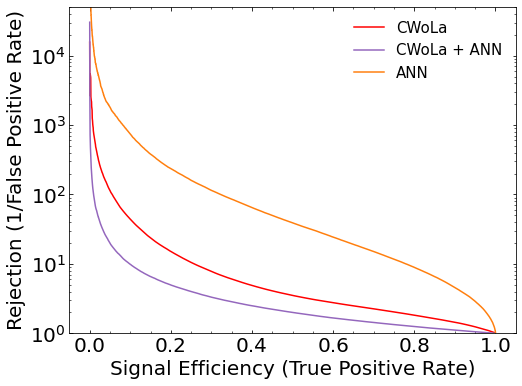

In [39]:
# Plot without banding
mylambda=.5
myklambda = 1 #np.round(len(SR_background_data)/len(SR_background_sim), 3)

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1])
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.yscale("log")
plt.ylim([1,5*1e4])
ERR=False
#plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')

for band in bands:
    if band in ['old-sacwola', 'hl-sacwola']:
        continue
    mu,std = bands[band][3:5]

    plt.plot(tpr_pts, mu, **bands[band][-1])
    if ERR:
        plt.fill_between(tpr_pts, mu - std, mu + std, alpha=.2, color=bands[band][-1]['color'])
#plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=20)
plt.legend(frameon=False,fontsize=15,loc="upper right")

# plt.title("Correlated LHCO Example\n(Median of {} models)".format(n_injections),fontsize=20,)
#plt.savefig('C:/Users/knukl/Desktop/FINAL/plots/combined_corr_deltamj_extracorr.pdf', pdf=True, bbox_inches='tight')
#plt.savefig('C:/Users/knukl/Desktop/FINAL/plots/combined_corr_deltamj_extracorr.png', pdf=False, bbox_inches='tight')
# plt.show()

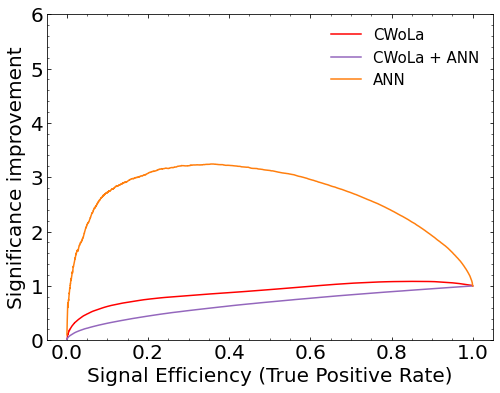

In [41]:
# Plot without banding
mylambda=.5
myklambda = 1 #np.round(len(SR_background_data)/len(SR_background_sim), 3)

ERR = False

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1])
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.ylim([0, 6])



for band in bands:
    if band in ['old-sacwola', 'hl-sacwola']:
        continue
    mu,std = bands[band][5:7]
    plt.plot(tpr_pts, tpr_pts*mu, **bands[band][-1])
#plt.plot(tpr_sup,tpr_sup/np.sqrt(tpr_sup),color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Significance improvement",fontsize=20)
plt.legend(frameon=False,fontsize=15,loc="upper right")
#plt.title(r'$LHC$ $Olympics$ $Example$', loc='right', fontsize=20)

#plt.savefig('C:/Users/knukl/Desktop/FINAL/plots/combined_relsigs_corr_deltamj_extracorr.pdf', pdf=True, bbox_inches='tight')
#plt.savefig('C:/Users/knukl/Desktop/FINAL/plots/combined_relsigs_corr_deltamj_extracorr.png', pdf=False, bbox_inches='tight')